In [ ]:
import torch as trc, matplotlib.pyplot as plt, numpy as np

import  torchvision
from torchvision import transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Data Review and Preparation

In [ ]:
!unzip -q drive/MyDrive/VKR/data_cls.zip

In [ ]:
size, sharpness = 256, 10

read_img = transforms.Compose([
  transforms.Resize((size, size)),
  transforms.ToTensor(),
  transforms.Grayscale(),
  transforms.RandomAdjustSharpness(sharpness, 1),

  # transforms.Normalize(mean, std),
])

augm_img = transforms.Compose([
  transforms.Resize((size, size)),
  transforms.ToTensor(),
  transforms.Grayscale(),
  transforms.RandomAdjustSharpness(sharpness, 1),

  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomRotation(180),
  
  # transforms.ColorJitter(0.1, 0.5, 0.5, 0.5),
  # transforms.RandomInvert(0.5),
  # transforms.RandomGrayscale(),
  # transforms.Normalize(mean, std),
])

In [ ]:
dt_train = torchvision.datasets.ImageFolder('Data', augm_img)
dt_test = torchvision.datasets.ImageFolder('Data', read_img)

n = len(dt_train)
rng_0, rng_1 = list(range(n//2)), list(range(n//2, n))
train_inds_0, test_inds_0 = train_test_split(rng_0, test_size=0.25,
                                             random_state=0, shuffle=True)
train_inds_1, test_inds_1 = train_test_split(rng_1, test_size=0.25,
                                             random_state=0, shuffle=True)
train_inds = train_inds_0 + train_inds_1
test_inds = test_inds_0 + test_inds_1

dt_train = trc.utils.data.Subset(dt_train, train_inds)
dt_test = trc.utils.data.Subset(dt_test, test_inds)

n, len(dt_train), len(dt_test)

(400, 300, 100)

In [ ]:
dt_train[0][0].shape

torch.Size([1, 256, 256])

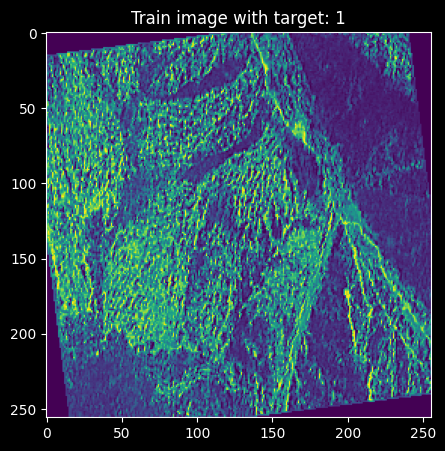

In [ ]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10, 5)

# plt.imshow(dt_train[0][0].permute(1, 2, 0))
plt.imshow(dt_train[200][0][0])
plt.title('Train image with target: '+str(dt_train[200][1]));

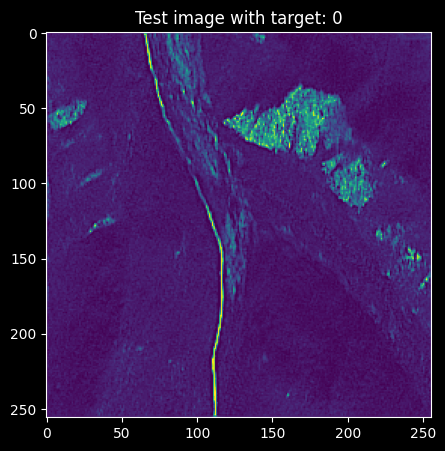

In [ ]:
# plt.imshow(dt_test[0][0].permute(1, 2, 0))
plt.imshow(dt_test[0][0][0])
plt.title('Test image with target: '+str(dt_test[0][1]));

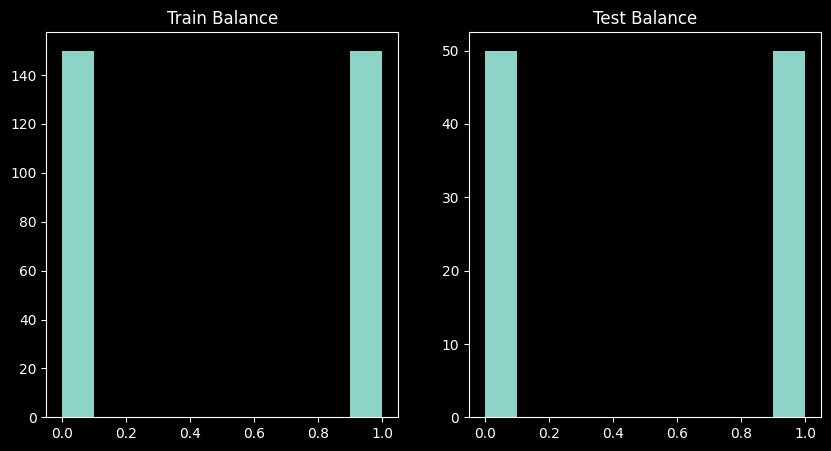

In [ ]:
y_train, y_test = [i[1] for i in dt_train], [j[1] for j in dt_test]

plt.subplot(121)
plt.hist(y_train)
plt.title('Train Balance')

plt.subplot(122)
plt.hist(y_test)
plt.title('Test Balance');

In [ ]:
batch_size = 50

train_dl = trc.utils.data.DataLoader(dt_train, batch_size,
                                     shuffle=True, drop_last=False,
                                     num_workers=2)
test_dl = trc.utils.data.DataLoader(dt_test, len(dt_test), num_workers=2)

# Neural Net Class

In [ ]:
class ClsNet(trc.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv3_1 = trc.nn.Conv2d(1, 2, 3, padding=1)
    self.conv3_2 = trc.nn.Conv2d(2, 4, 3, padding=1)
    self.conv3_3 = trc.nn.Conv2d(4, 8, 3, padding=1)
    self.conv3_4 = trc.nn.Conv2d(8, 16, 3, padding=1)
    self.conv3_5 = trc.nn.Conv2d(16, 32, 3, padding=1)
    
    self.pool = trc.nn.MaxPool2d(2)

    self.fc_1 = trc.nn.Linear(32*8*8, 256)
    self.fc_2 = trc.nn.Linear(256, 128)
    self.fc_3 = trc.nn.Linear(128, 64)
    self.fc_4 = trc.nn.Linear(64, 32)
    self.fc_5 = trc.nn.Linear(32, 1)

    self.relu = trc.nn.ReLU()
    self.sig = trc.nn.Sigmoid()
  
  def forward(self, x):
    x = self.relu(self.pool(self.conv3_1(x)))
    x = self.relu(self.pool(self.conv3_2(x)))
    x = self.relu(self.pool(self.conv3_3(x)))
    x = self.relu(self.pool(self.conv3_4(x)))
    x = self.relu(self.pool(self.conv3_5(x)))

    x = x.reshape(x.shape[0], -1)

    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = self.relu(self.fc_4(x))

    return self.sig(self.fc_5(x)).squeeze()

# Net Init, Loss and Optimizer

In [ ]:
np.random.seed(1)
trc.manual_seed(1)
trc.cuda.manual_seed(1)
trc.backends.cudnn.determenistic = True

In [ ]:
device = ('cuda:0' if trc.cuda.is_available() else 'cpu')

net = ClsNet().to(device)
loss = trc.nn.BCELoss()
# optimizer = trc.optim.Adam(net.parameters(), lr=0.001, amsgrad=True)
# optimizer = trc.optim.NAdam(net.parameters(), lr=0.001)
optimizer = trc.optim.Adagrad(net.parameters(), lr=0.01)

# scheduler = trc.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

device

'cuda:0'

# Learning

In [ ]:
train_loss_hist, train_accuracy_hist = [], []
test_loss_hist, test_accuracy_hist = [], []
max_acc = 0
# lr_red, k = [0.90, 0.95], 0

for epoch in tqdm(range(25)):
  net.train()

  for i in range(0, len(dt_train), batch_size):
    acc_sum, loss_sum, batch_n = 0, 0, 0

    for input, targets in train_dl:
      input = input.to(device)
      targets = targets.to(device).float()

      preds = net.forward(input)
      loss_val = loss(preds, targets)
      loss_val.backward()

      acc_sum += ((preds.data>=0.5).int() == targets).float().mean().cpu()
      loss_sum += loss_val.data.cpu()
      batch_n += 1

      optimizer.step()
      optimizer.zero_grad()
  
  train_accuracy_hist.append(acc_sum/batch_n)
  train_loss_hist.append(loss_sum/batch_n)
  net.eval()

  for input, targets in test_dl:
    input = input.to(device)
    targets = targets.to(device).float()

    with trc.set_grad_enabled(False):
      preds = net.forward(input).data
      loss_val = loss(preds, targets).data.cpu()
      accuracy = ((preds.data>=0.5).int() == targets).data.float().mean().cpu()

    test_accuracy_hist.append(accuracy)
    test_loss_hist.append(loss_val)

    if accuracy >= max_acc:
      trc.save(net, 'classification_model')
      max_acc = accuracy

    '''if k < len(lr_red) and accuracy > lr_red[k]:
      scheduler.step()
      k+=1'''

100%|██████████| 25/25 [11:34<00:00, 27.76s/it]


# Statistics

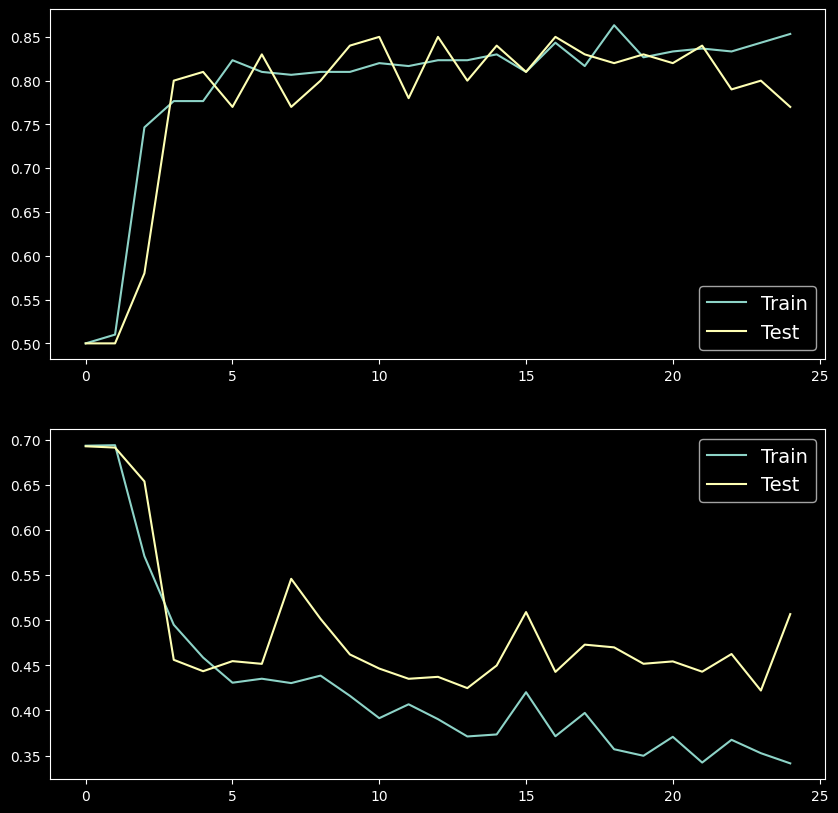

In [ ]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10, 10)

axs[0].plot(train_accuracy_hist, label='Train')
axs[0].plot(test_accuracy_hist, label='Test')
axs[0].legend(fontsize=14, loc='lower right')

axs[1].plot(train_loss_hist, label='Train')
axs[1].plot(test_loss_hist, label='Test')
axs[1].legend(fontsize=14);

# Testing

In [ ]:
net_test = trc.load('classification_model')
preds, targets = trc.tensor([]), trc.tensor([])

for X, y in test_dl:
  with trc.set_grad_enabled(False):
    res = (net_test.forward(X.to(device)).data >= 0.5).int().cpu()

  preds = trc.cat([preds, res])
  targets = trc.cat([targets, y])

print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86        50
         1.0       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

